# Current

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd

import h5py
import itertools

import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import rc
from string import ascii_letters

from sklearn.preprocessing import RobustScaler

%matplotlib inline

In [3]:
import torch

import copy
import numpy as np
import pandas as pd
import seaborn as sns

from pylab import rcParams
from sklearn.model_selection import train_test_split

from torch import nn, optim
import torch.nn.functional as F

In [4]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [5]:
#folder_path = "C:/Users/qhrrl/CodeExamples/3.Paper/0.Dataset" # local
folder_path = "/content/drive/MyDrive/Paper/Dataset" # cloud

pd_tr = pd.read_csv(folder_path + '/cur_training_all.csv')
pd_v = pd.read_csv(folder_path + '/cur_validation_all.csv')

In [6]:
print(len(pd_tr))
print(len(pd_v))
print(pd_tr.shape)
print(pd_v.shape)

305534
38210
(305534, 48)
(38210, 48)


In [7]:
pd_tr_labels = pd_tr.iloc[:, -1]
pd_v_labels = pd_v.iloc[:, -1]

In [8]:
CLASS_NORMAL = 0
class_names = ['NORMAL','ab1','ab2','ab3','ab4']

In [9]:
new_columns = list(pd_tr.columns)
new_columns[-1] = 'LABEL'
pd_tr.columns = new_columns

In [10]:
pd_tr.head(5)

,Date,R_AbsMax,S_AbsMax,T_AbsMax,R_AbsMean,S_AbsMean,T_AbsMean,R_P2P,S_P2P,T_P2P,R_RMS,S_RMS,T_RMS,R_Skewness,S_Skewness,T_Skewness,R_Kurtosis,S_Kurtosis,T_Kurtosis,R_Crest,S_Crest,T_Crest,R_Shape,S_Shape,T_Shape,R_Impulse,S_Impulse,T_Impulse,RS_phase,ST_phase,TR_phase,RS_Level,ST_Level,TR_Level,R_1x,S_1x,T_1x,R_2x,S_2x,T_2x,R_3x,S_3x,T_3x,R_4x,S_4x,T_4x,WATT,LABEL
0,2020-11-13 07:43:41,3.643555,3.883789,4.124023,2.152260,2.154582,2.290735,7.126953,7.527344,7.687500,2.393055,2.405278,2.559434,0.003421,0.002011,-0.002092,1.491381,1.539047,1.517514,2.978182,3.129510,3.003594,1.111880,1.116355,1.117298,1.692897,1.802572,1.800306,-3.141593,3.141593,-3.141593,-0.181417,2.754963,-2.573546,0.002448,0.004323,0.003780,3.536451,3.553066,3.763136,0.021705,0.023957,0.020911,0.057528,0.057195,0.057517,2.2,0
1,2020-11-13 07:43:41,3.643555,3.803711,4.164062,2.161249,2.163811,2.301946,7.126953,7.447266,7.727539,2.405001,2.415769,2.573205,0.000052,0.008745,-0.003142,1.491265,1.538511,1.518381,2.963389,3.082773,3.003080,1.112783,1.116442,1.117839,1.685856,1.757876,1.808932,-3.141593,-3.141593,-3.141593,-0.181857,2.755303,-2.573446,0.007313,0.011833,0.012369,3.521399,3.533756,3.747315,0.009876,0.010175,0.010687,0.011616,0.013211,0.010941,2.2,0
2,2020-11-13 07:43:41,3.683594,3.803711,4.164062,2.152920,2.151939,2.289333,7.166992,7.367188,7.727539,2.394561,2.401572,2.559190,0.004258,0.002918,-0.004127,1.491505,1.537529,1.517569,2.993029,3.067652,3.019525,1.112239,1.116004,1.117876,1.710975,1.767573,1.818897,-3.141593,-3.141593,3.141593,-0.103641,2.676847,-2.573206,0.010866,0.016296,0.012448,3.506221,3.519853,3.728701,0.017622,0.011568,0.014016,0.012954,0.016530,0.011328,2.2,0
3,2020-11-13 07:44:42,3.553467,3.753662,3.993896,2.134172,2.111470,2.258483,6.966797,7.247070,7.487305,2.371624,2.353266,2.520865,-0.000152,0.001546,0.000843,1.490338,1.533833,1.517199,2.937564,3.079579,2.970133,1.111262,1.114516,1.116176,1.665033,1.777748,1.768398,-3.141593,3.141593,-3.141593,-0.099437,2.592504,-2.493067,0.008985,0.014649,0.011038,3.385902,3.359254,3.581625,0.011735,0.008646,0.012069,0.008928,0.008072,0.006405,2.2,0
4,2020-11-13 07:44:42,3.593506,3.713623,4.073975,2.137425,2.114743,2.260646,7.006836,7.247070,7.607422,2.374335,2.356919,2.524138,0.001741,0.006429,-0.004894,1.489275,1.535224,1.518454,2.951073,3.074806,3.013869,1.110839,1.114518,1.116556,1.681231,1.756063,1.802129,-3.141593,3.141593,3.141593,-0.141278,2.634706,-2.493428,0.007743,0.009151,0.007339,3.380960,3.354816,3.573826,0.007737,0.006841,0.007718,0.011826,0.016674,0.015070,2.2,0


In [11]:
print(np.mean(pd_tr['LABEL']))

0.7715867955775789


In [12]:
pd_tr.LABEL.value_counts()

0    218194
3     29066
4     24000
2     18274
1     16000
Name: LABEL, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


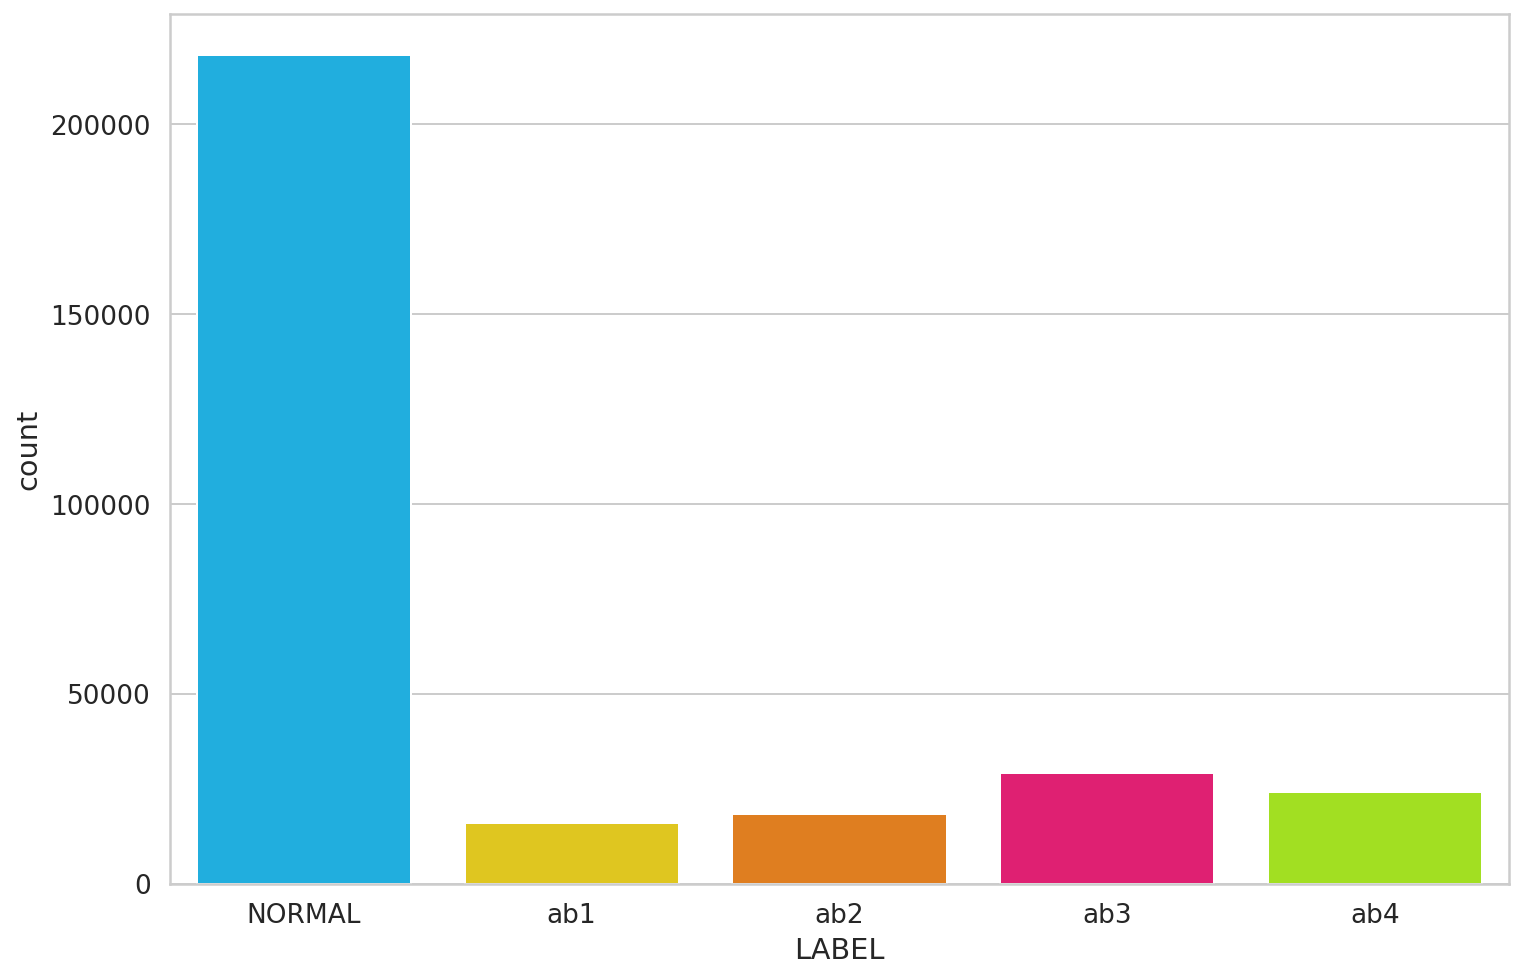

In [13]:
ax = sns.countplot(pd_tr.LABEL)
ax.set_xticklabels(class_names);

In [14]:
def plot_time_series_class(data, class_name, ax, n_steps=10):
  time_series_df = pd.DataFrame(data)

  smooth_path = time_series_df.rolling(n_steps).mean()
  path_deviation = 2 * time_series_df.rolling(n_steps).std()

  under_line = (smooth_path - path_deviation)[0]
  over_line = (smooth_path + path_deviation)[0]

  ax.plot(smooth_path, linewidth=2)
  ax.fill_between(path_deviation.index, under_line, over_line, alpha=.125)
  ax.set_title(class_name)

In [15]:
classes = pd_tr.LABEL.unique()

In [16]:
# fig, axs = plt.subplots(
#   nrows=len(classes) // 3 + 1,
#   ncols=3,
#   sharey=True,
#   figsize=(14, 8)
# )

# for i, cls in enumerate(classes):
#   ax = axs.flat[i]
#   data = pd_tr[pd_tr.LABEL == cls].drop(labels='LABEL', axis=1).mean(axis=0).to_numpy()
#   plot_time_series_class(data, class_names[i], ax)

# fig.delaxes(axs.flat[-1])
# fig.tight_layout();

# anomaly detection

In [26]:
normal_df = pd_tr[pd_tr.LABEL == 0].drop(labels='LABEL', axis=1)
# normal_df = pd_tr[pd_tr.target == str(CLASS_NORMAL)].drop(labels='target', axis=1)

normal_df = normal_df.drop(columns = ['Date', 'WATT'])
normal_df = normal_df.drop(["R_Skewness", "S_Skewness", "T_Skewness", "R_Kurtosis", "R_Impulse", "ST_phase", "TR_phase","T_Kurtosis", "RS_Level"],axis=1)
normal_df.shape

(218194, 36)

In [27]:
normal_df

,R_AbsMax,S_AbsMax,T_AbsMax,R_AbsMean,S_AbsMean,T_AbsMean,R_P2P,S_P2P,T_P2P,R_RMS,S_RMS,T_RMS,S_Kurtosis,R_Crest,S_Crest,T_Crest,R_Shape,S_Shape,T_Shape,S_Impulse,T_Impulse,RS_phase,ST_Level,TR_Level,R_1x,S_1x,T_1x,R_2x,S_2x,T_2x,R_3x,S_3x,T_3x,R_4x,S_4x,T_4x
0,3.643555,3.883789,4.124023,2.152260,2.154582,2.290735,7.126953,7.527344,7.687500,2.393055,2.405278,2.559434,1.539047,2.978182,3.129510,3.003594,1.111880,1.116355,1.117298,1.802572,1.800306,-3.141593,2.754963,-2.573546,0.002448,0.004323,0.003780,3.536451,3.553066,3.763136,0.021705,0.023957,0.020911,0.057528,0.057195,0.057517
1,3.643555,3.803711,4.164062,2.161249,2.163811,2.301946,7.126953,7.447266,7.727539,2.405001,2.415769,2.573205,1.538511,2.963389,3.082773,3.003080,1.112783,1.116442,1.117839,1.757876,1.808932,-3.141593,2.755303,-2.573446,0.007313,0.011833,0.012369,3.521399,3.533756,3.747315,0.009876,0.010175,0.010687,0.011616,0.013211,0.010941
2,3.683594,3.803711,4.164062,2.152920,2.151939,2.289333,7.166992,7.367188,7.727539,2.394561,2.401572,2.559190,1.537529,2.993029,3.067652,3.019525,1.112239,1.116004,1.117876,1.767573,1.818897,-3.141593,2.676847,-2.573206,0.010866,0.016296,0.012448,3.506221,3.519853,3.728701,0.017622,0.011568,0.014016,0.012954,0.016530,0.011328
3,3.553467,3.753662,3.993896,2.134172,2.111470,2.258483,6.966797,7.247070,7.487305,2.371624,2.353266,2.520865,1.533833,2.937564,3.079579,2.970133,1.111262,1.114516,1.116176,1.777748,1.768398,-3.141593,2.592504,-2.493067,0.008985,0.014649,0.011038,3.385902,3.359254,3.581625,0.011735,0.008646,0.012069,0.008928,0.008072,0.006405
4,3.593506,3.713623,4.073975,2.137425,2.114743,2.260646,7.006836,7.247070,7.607422,2.374335,2.356919,2.524138,1.535224,2.951073,3.074806,3.013869,1.110839,1.114518,1.116556,1.756063,1.802129,-3.141593,2.634706,-2.493428,0.007743,0.009151,0.007339,3.380960,3.354816,3.573826,0.007737,0.006841,0.007718,0.011826,0.016674,0.015070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305529,3.803711,4.003906,4.003906,2.252598,2.304028,2.266311,7.567383,7.927734,7.807617,2.489622,2.572182,2.505245,1.535384,3.039571,3.082105,3.116508,1.105223,1.116385,1.105429,1.737786,1.766706,3.141593,2.931595,-2.770698,0.028741,0.027557,0.027752,3.559418,3.684790,3.580361,0.093621,0.091038,0.093348,0.007971,0.003863,0.006197
305530,3.763672,4.003906,4.003906,2.255460,2.308152,2.267592,7.527344,7.927734,7.767578,2.492816,2.576773,2.507228,1.536397,3.019615,3.076613,3.098074,1.105236,1.116380,1.105678,1.734681,1.765708,3.141593,2.931155,-2.771239,0.029346,0.029110,0.029658,3.549892,3.668430,3.571321,0.089815,0.083217,0.092134,0.010085,0.006868,0.008668
305531,3.723633,3.963867,3.963867,2.237843,2.294679,2.255941,7.447266,7.847656,7.727539,2.473645,2.561777,2.493650,1.535740,3.010644,3.063364,3.098887,1.105370,1.116399,1.105370,1.727417,1.757079,3.141593,2.888413,-2.731720,0.028960,0.028904,0.030973,3.629977,3.762358,3.654498,0.092995,0.092244,0.094533,0.010208,0.029431,0.030930
305532,3.763672,3.923828,3.963867,2.236702,2.291616,2.252798,7.487305,7.807617,7.727539,2.472197,2.557415,2.490302,1.534979,3.028603,3.052933,3.103053,1.105287,1.115988,1.105426,1.712254,1.759531,3.141593,2.888153,-2.770979,0.036846,0.035674,0.037423,3.625970,3.755750,3.648903,0.103550,0.101582,0.107555,0.008367,0.001673,0.008206


In [28]:
anomaly_df = pd_tr[pd_tr.LABEL != CLASS_NORMAL].drop(labels='LABEL', axis=1)
anomaly_df = anomaly_df.drop(columns = ['Date', 'WATT'])
anomaly_df = anomaly_df.drop(["R_Skewness", "S_Skewness", "T_Skewness", "R_Kurtosis", "R_Impulse", "ST_phase", "TR_phase","T_Kurtosis", "RS_Level"],axis=1)
anomaly_df.shape

(87340, 36)

In [29]:
train_df, val_df = train_test_split(
  normal_df,
  test_size=0.15,
  random_state=RANDOM_SEED
)

val_df, test_df = train_test_split(
  val_df,
  test_size=0.33, 
  random_state=RANDOM_SEED
)

In [30]:
def create_dataset(df):
  sequences = df.astype(np.float32).to_numpy().tolist()
  dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]
  n_seq, seq_len, n_features = torch.stack(dataset).shape
  return dataset, seq_len, n_features

In [31]:
train_df

,R_AbsMax,S_AbsMax,T_AbsMax,R_AbsMean,S_AbsMean,T_AbsMean,R_P2P,S_P2P,T_P2P,R_RMS,S_RMS,T_RMS,S_Kurtosis,R_Crest,S_Crest,T_Crest,R_Shape,S_Shape,T_Shape,S_Impulse,T_Impulse,RS_phase,ST_Level,TR_Level,R_1x,S_1x,T_1x,R_2x,S_2x,T_2x,R_3x,S_3x,T_3x,R_4x,S_4x,T_4x
300431,3.758667,3.968872,3.998901,2.234270,2.290930,2.269900,7.447266,7.927734,7.847656,2.466074,2.556312,2.510743,1.534393,3.019887,3.101239,3.125631,1.103749,1.115840,1.106103,1.732428,1.761709,3.141593,2.974757,-2.687938,0.022569,0.025905,0.025301,3.607744,3.745367,3.673725,0.168107,0.164747,0.172811,0.024993,0.011251,0.018026
244481,4.279175,4.719604,4.519409,2.526845,2.577420,2.538376,8.408203,8.848633,8.848633,2.787304,2.881875,2.814464,1.529161,3.016607,3.070443,3.143985,1.103077,1.118124,1.108766,1.831136,1.780433,3.141593,3.415828,-3.196754,0.012945,0.011735,0.009699,4.033833,4.154171,4.075715,0.012923,0.015491,0.013065,0.033981,0.024298,0.022163
162811,5.004883,5.645508,5.245117,2.766279,3.018004,2.786358,9.489258,10.930664,10.049805,3.064751,3.373207,3.107139,1.552856,3.096257,3.240437,3.234424,1.107897,1.117695,1.115125,1.870610,1.882427,3.141593,4.451638,-3.746190,0.013020,0.021577,0.016044,4.426503,4.887607,4.485988,0.027707,0.026121,0.026444,0.044750,0.051217,0.038973
37326,3.433350,3.153076,3.913818,2.044525,1.864689,2.196453,6.766602,6.246094,7.367188,2.266508,2.084779,2.441661,1.498826,2.985474,2.996047,3.017286,1.108575,1.118030,1.111638,1.690939,1.781881,-3.141593,2.138622,-2.338597,0.009083,0.008862,0.012216,3.337471,3.069146,3.578597,0.012836,0.009352,0.011983,0.041625,0.038567,0.037220
197074,4.204102,4.404297,4.324219,2.429750,2.459880,2.407329,8.328125,8.648438,8.448242,2.699692,2.754793,2.678487,1.551377,3.084843,3.139414,3.154109,1.111098,1.119889,1.112639,1.790452,1.796273,3.141593,3.306661,-3.124503,0.018524,0.018947,0.026853,3.878527,3.960462,3.848360,0.023904,0.019780,0.020563,0.027059,0.020737,0.013538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183219,4.249146,4.439331,4.319214,2.384792,2.449405,2.368521,8.288086,8.728516,8.448242,2.648786,2.743104,2.632373,1.552999,3.129013,3.181985,3.209364,1.110699,1.119906,1.111400,1.812412,1.823591,3.141593,3.345759,-3.170568,0.021280,0.020515,0.019283,3.839662,3.976947,3.816174,0.019320,0.017202,0.022697,0.008845,0.010207,0.009030
167034,4.209106,4.399292,4.359253,2.350358,2.438619,2.362500,8.288086,8.688477,8.528320,2.604171,2.722275,2.624272,1.541429,3.182619,3.191624,3.249785,1.107989,1.116318,1.110803,1.804009,1.845187,3.141593,3.348001,-3.130609,0.024094,0.032416,0.035697,3.726932,3.900944,3.759952,0.037578,0.030504,0.033664,0.020503,0.011904,0.013116
195272,4.324219,4.484375,4.524414,2.426387,2.476236,2.440281,8.488281,8.888672,8.808594,2.685587,2.762040,2.708646,1.552146,3.160680,3.218154,3.252029,1.106825,1.115419,1.109973,1.810964,1.854055,3.141593,3.465316,-3.244541,0.014242,0.016727,0.017334,3.856607,3.968679,3.888279,0.021718,0.020952,0.023943,0.011976,0.031649,0.022764
210207,4.083984,4.204102,4.204102,2.404586,2.435576,2.393175,8.007812,8.328125,8.208008,2.659252,2.715002,2.649530,1.531828,3.011303,3.067447,3.097911,1.105908,1.114727,1.107119,1.726122,1.756705,3.141593,3.183461,-3.007329,0.015918,0.017381,0.017056,3.953590,4.042275,3.939943,0.028192,0.031768,0.029085,0.028340,0.017062,0.016450


In [32]:
train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
test_normal_dataset, _, _ = create_dataset(test_df)
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

In [33]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))

In [34]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

In [35]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [37]:
model = RecurrentAutoencoder(seq_len, n_features, 128)
model = model.to(device)

In [38]:
def train_model(model, train_dataset, val_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  criterion = nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0
  
  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad()

      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:

        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history

In [39]:
EPOCHS = 10
print(device)

cuda


In [40]:
model, history = train_model(
  model, 
  train_dataset, 
  val_dataset, 
  n_epochs=EPOCHS
)

Epoch 1: train loss 12.979620908695411 val loss 12.592615074188657
Epoch 2: train loss 12.875027693825594 val loss 12.63169765444416
Epoch 3: train loss 12.873516131044772 val loss 12.616541378801088
Epoch 4: train loss 12.873270504874174 val loss 12.62189202008525
Epoch 5: train loss 12.872848776401359 val loss 12.592511673765191
Epoch 6: train loss 12.869672577667318 val loss 12.604074563216976
Epoch 7: train loss 12.860441896554416 val loss 12.60694565162096
Epoch 8: train loss 12.858921569762142 val loss 12.60799545796866
Epoch 9: train loss 12.855953350336984 val loss 12.61734157664499
Epoch 10: train loss 12.852996338089909 val loss 12.583659555184227


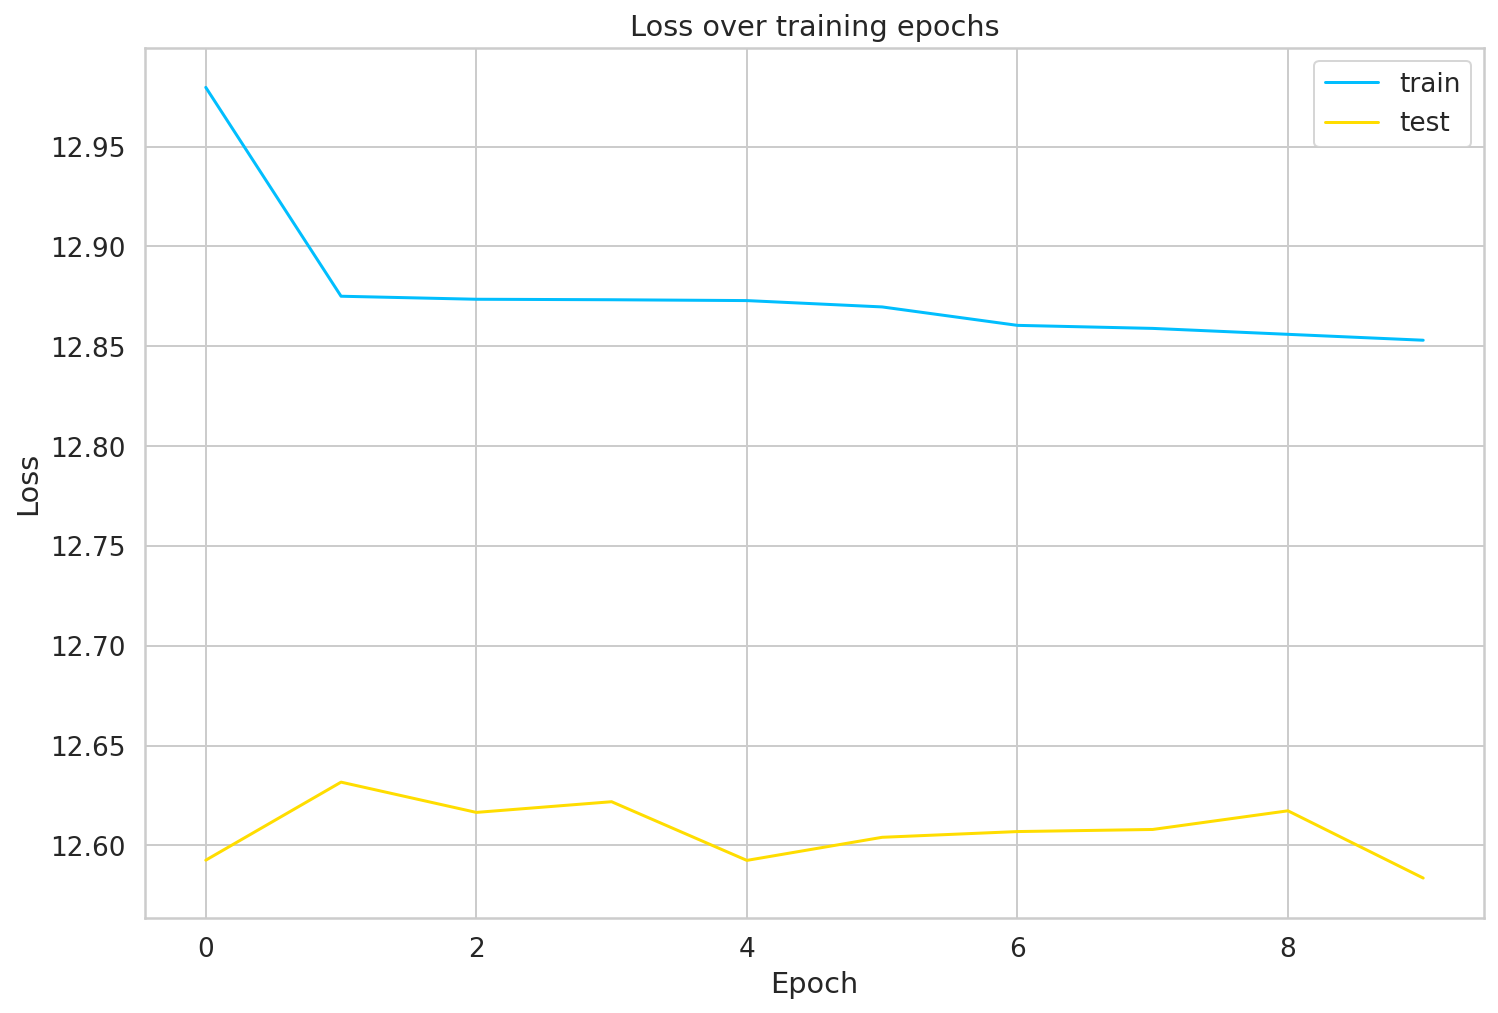

In [41]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

In [42]:
MODEL_PATH = folder_path +'/cur_10epochs_model.pth'

torch.save(model, MODEL_PATH)

In [43]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


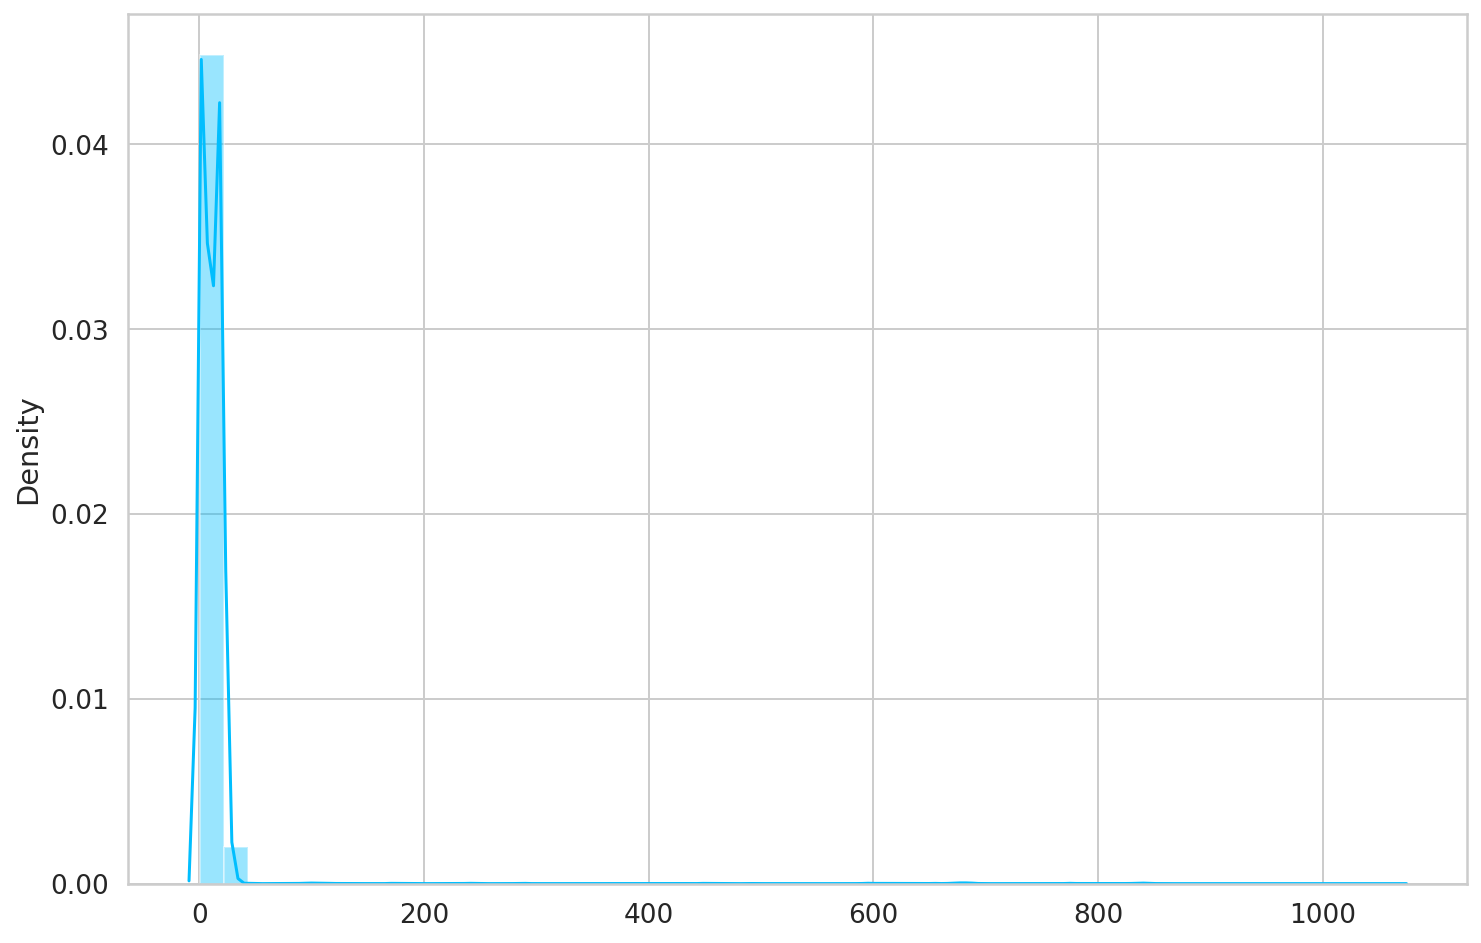

In [44]:
_, losses = predict(model, train_dataset)

sns.distplot(losses, bins=50, kde=True);

In [45]:
THRESHOLD = 26

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


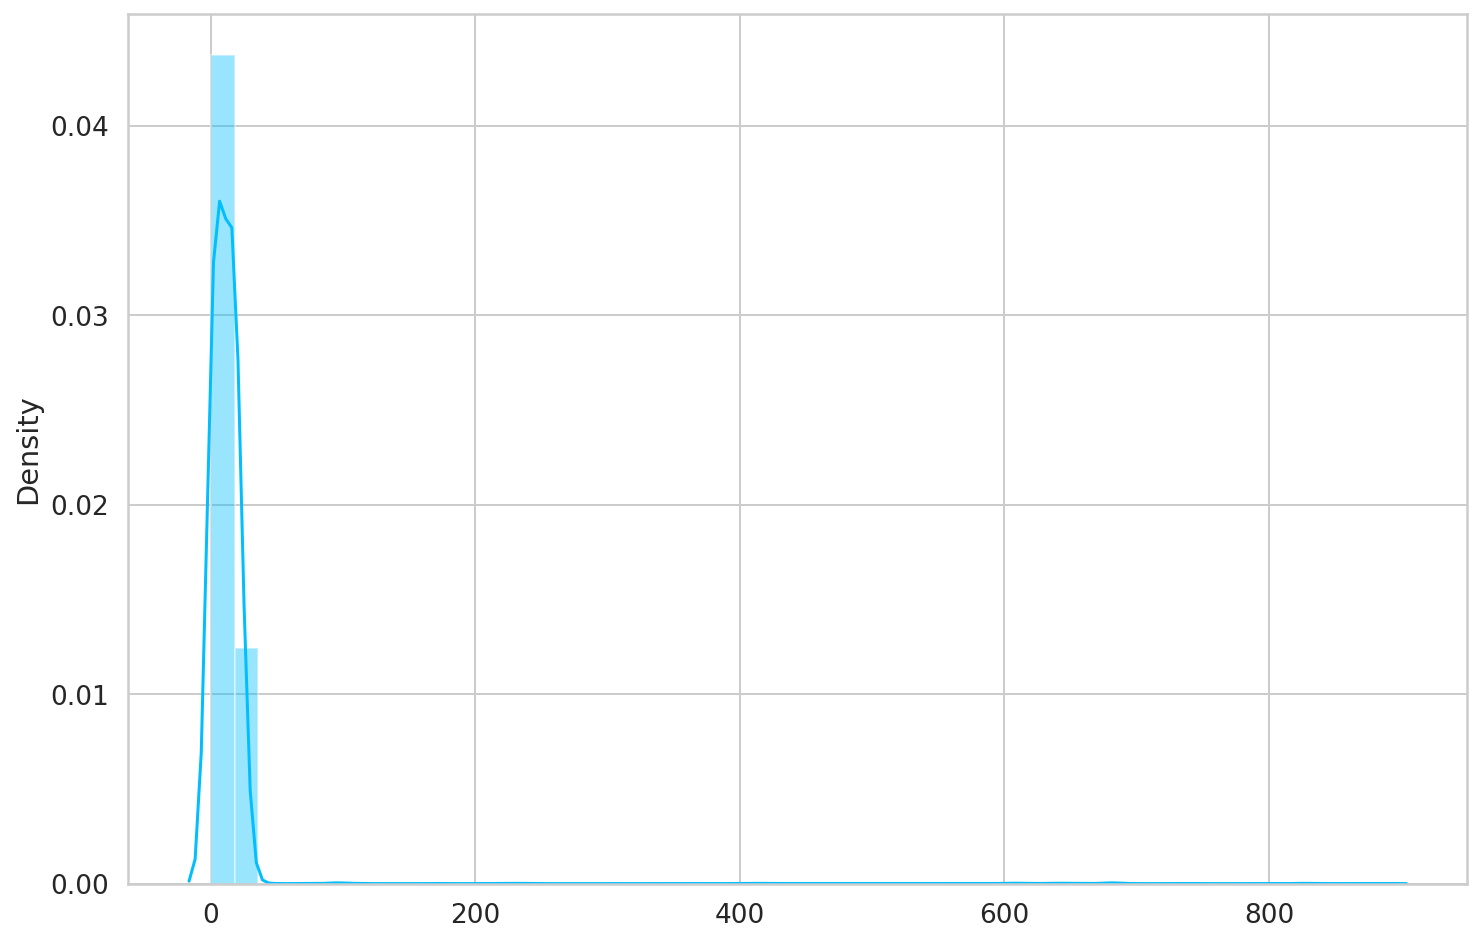

In [46]:
predictions, pred_losses = predict(model, test_normal_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

In [47]:
correct = sum(l <= THRESHOLD for l in pred_losses)
print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')

Correct normal predictions: 10655/10801


In [48]:
anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


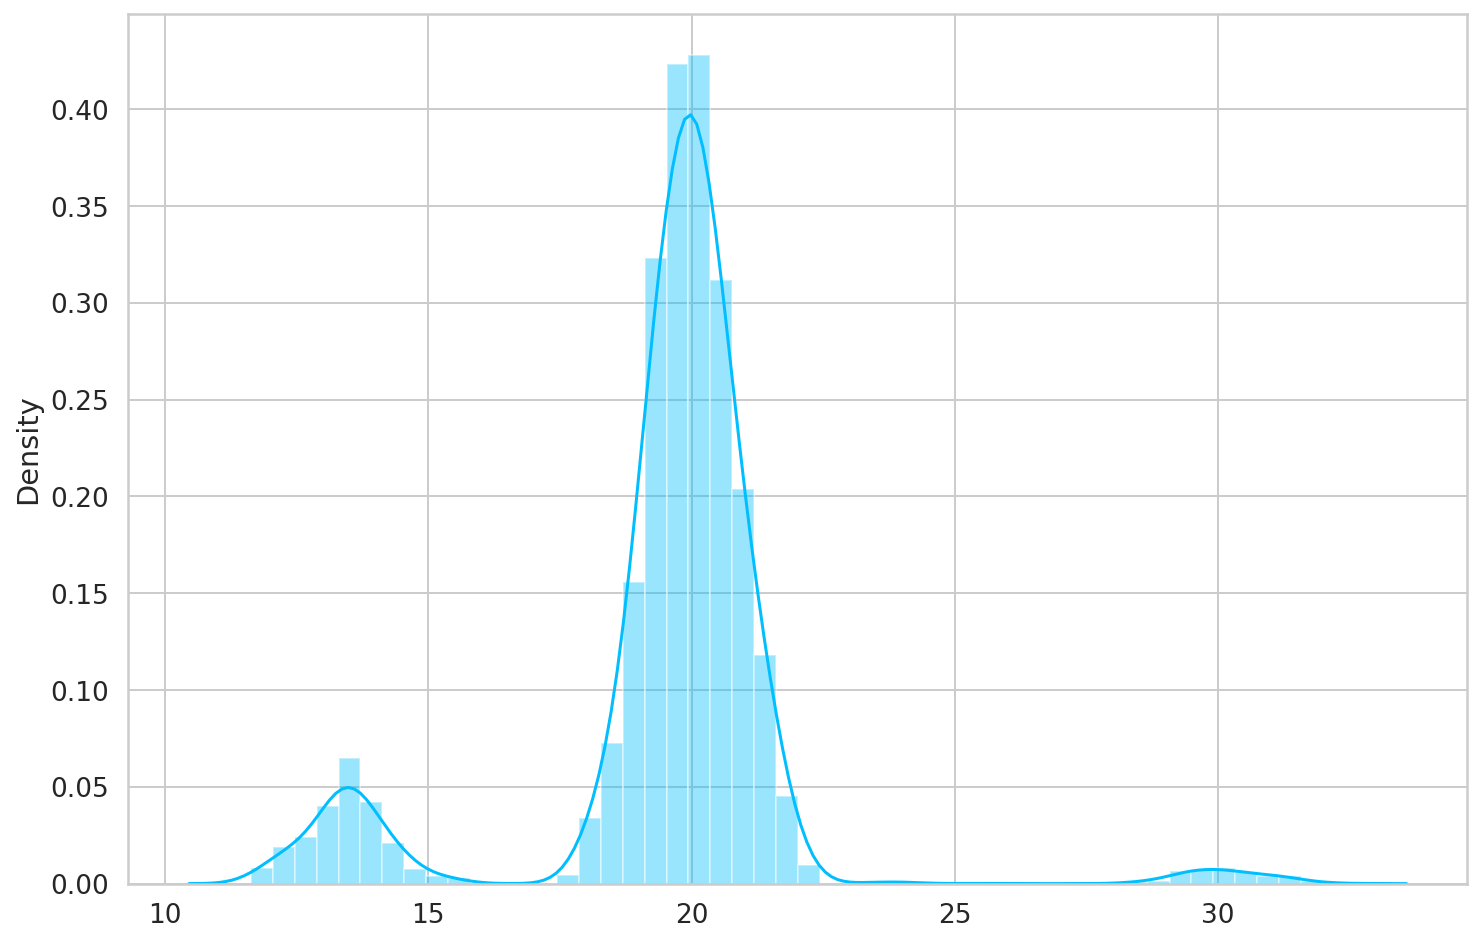

In [49]:
predictions, pred_losses = predict(model, anomaly_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

In [50]:
correct = sum(l > THRESHOLD for l in pred_losses)
print(f'Correct anomaly predictions: {correct}/{len(anomaly_dataset)}')

Correct anomaly predictions: 178/10801


In [51]:
def plot_prediction(data, model, title, ax):
  predictions, pred_losses = predict(model, [data])

  ax.plot(data, label='true')
  ax.plot(predictions[0], label='reconstructed')
  ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
  ax.legend()

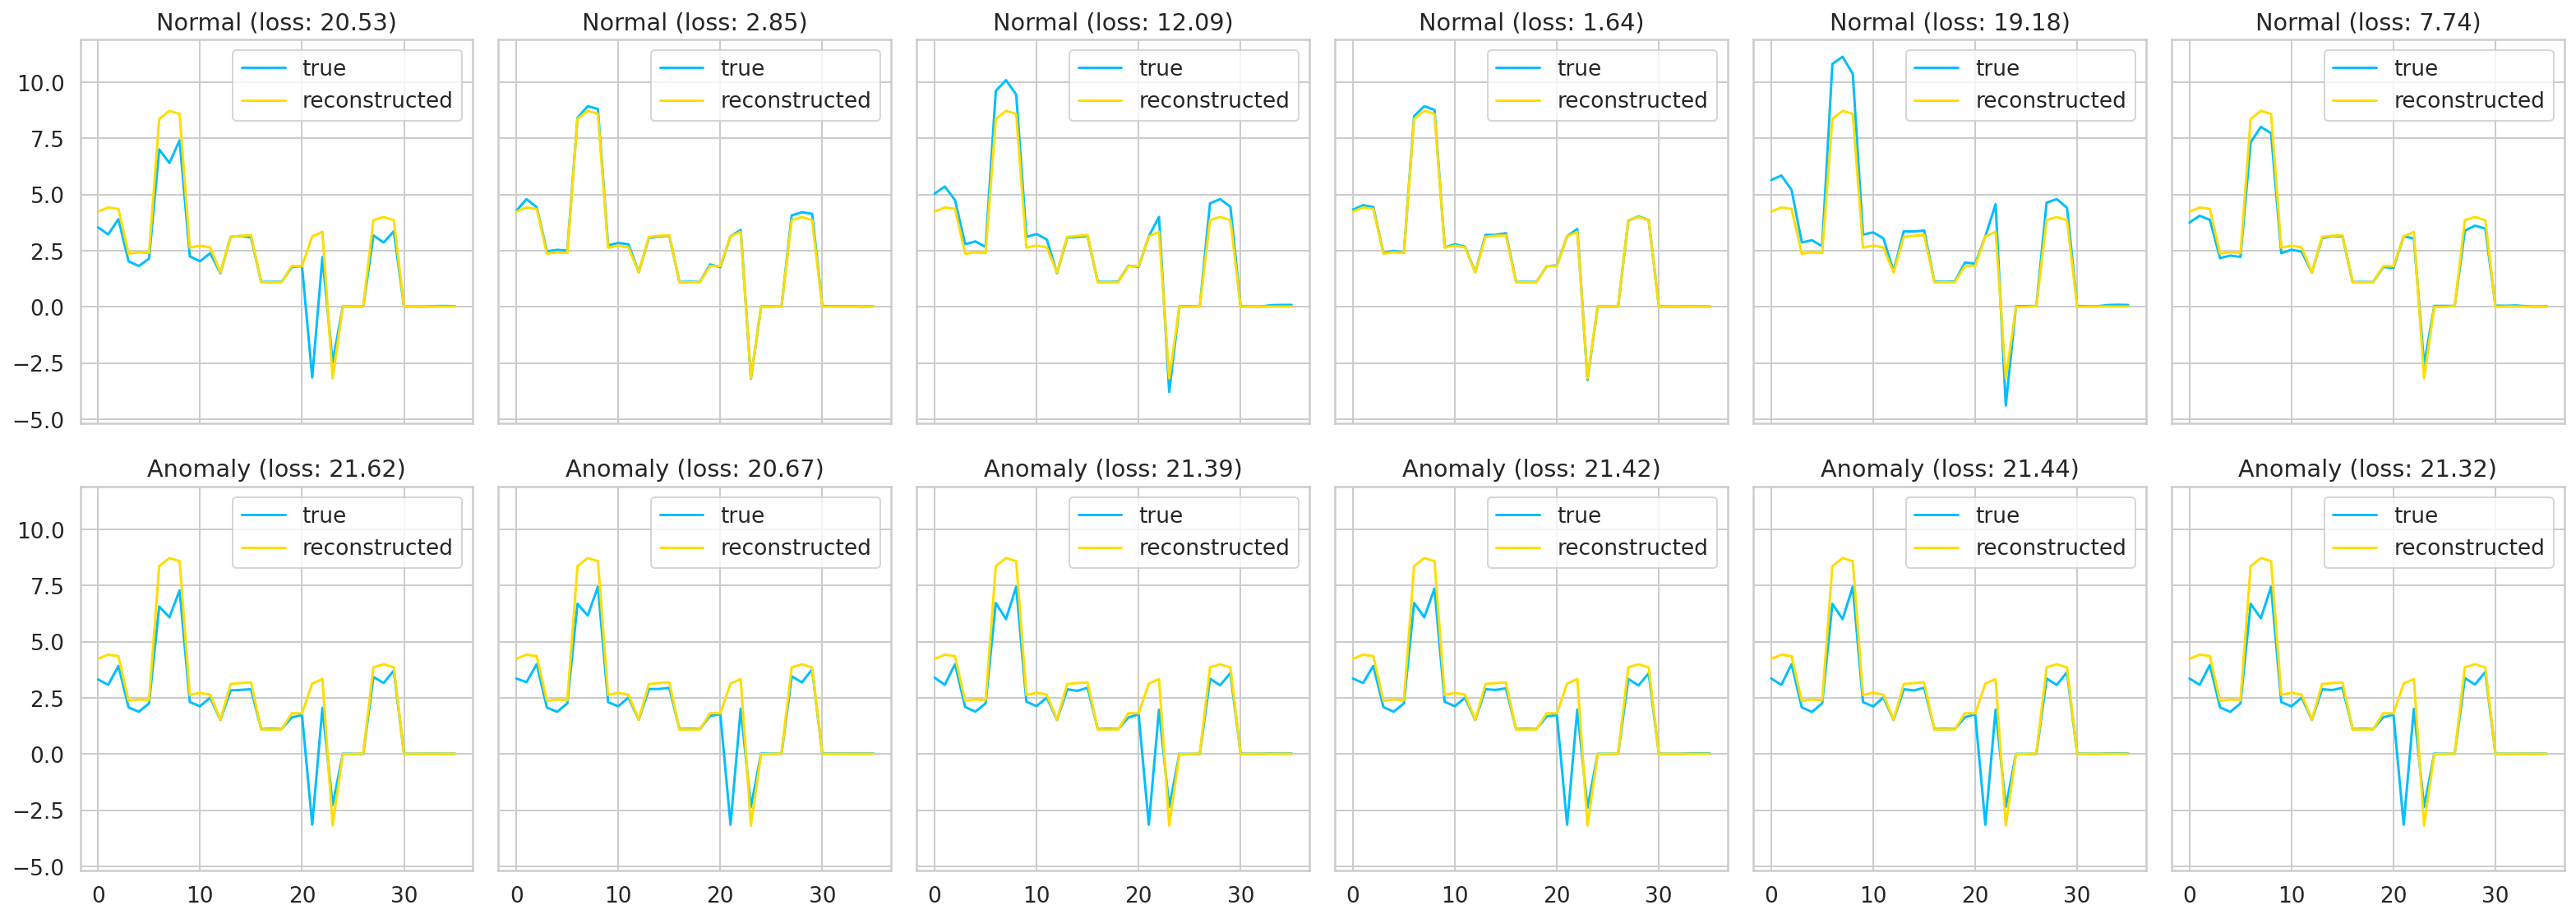

In [52]:
fig, axs = plt.subplots(
  nrows=2,
  ncols=6,
  sharey=True,
  sharex=True,
  figsize=(22, 8)
)

for i, data in enumerate(test_normal_dataset[:6]):
  plot_prediction(data, model, title='Normal', ax=axs[0, i])

for i, data in enumerate(test_anomaly_dataset[:6]):
  plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

fig.tight_layout();

In [ ]:
pd_tr = pd_tr.drop(columns = ['Date','WATT','LABEL'])
pd_v = pd_v.drop(columns = ['Date','WATT','LABEL'])

In [ ]:
# drop_corr_pd_tr = pd_tr.drop(["R_Skewness", "S_Skewness", "T_Skewness", "R_Kurtosis", "R_Impulse", "ST_phase", "TR_phase","T_Kurtosis", "RS_Level"],axis=1)
# drop_corr_pd_v = pd_v.drop(["R_Skewness", "S_Skewness", "T_Skewness", "R_Kurtosis", "R_Impulse", "ST_phase", "TR_phase","T_Kurtosis", "RS_Level"],axis=1)

In [ ]:
# def draw_seaborn_corr(corr_data):
#   sns.set_theme(style="white")

#   # Generate a large random dataset
#   rs = np.random.RandomState(33)
#   mask = np.triu(np.ones_like(corr_data, dtype=bool))

#   # Set up the matplotlib figure
#   f, ax = plt.subplots(figsize=(11, 9))

#   # Generate a custom diverging colormap
#   cmap = sns.diverging_palette(230, 20, as_cmap=True)

#   # Draw the heatmap with the mask and correct aspect ratio
#   sns.heatmap(corr_data, mask=mask, cmap=cmap, vmax=.3, center=0,
#               square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
# corr = drop_corr_pd_tr.corr()
# draw_seaborn_corr(corr)

### 1.1 split data set 

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(pd_tr, pd_tr_labels, test_size=0.2, random_state=42)

### 1.2. Validation

In [ ]:
print(x_train.shape)
print(y_train.shape)
print("="*50)
print(x_test.shape)
print(y_test.shape)
print("="*50)
x_valid = pd_v
y_valid = pd_v_labels

print(x_valid.shape)
print(y_valid.shape)

### 1.3 normalize

주제가 피쳐에 대한 강건함이므로, 스케일러에 대한 고민도 해야할 것이다.

본 데이터는 Multivariate이며, 1개의 Channel만 갖는다. 우리는 multivariate variable with one channel 형태로 바꿔주고자 하며, 이는 아래와 같다.

In [ ]:
# CNN, RNN 모델의 입력 변수는 채널 축 1개 차원을 확장시킨 3D Tensor이다.
# 즉 아래 CNN, RNN 모델은 x_train, x_valid, x_test를 입력 변수로 넣지 않고, 
# x_train_exp, x_valid_exp, x_test_exp을 넣는다. 
x_train_exp = np.expand_dims(x_train, -1)  # 채널 축 1개 차원을 확장 시킨(Expand) X_train
x_valid_exp = np.expand_dims(x_valid, -1)  # 채널 축 1개 차원을 확장 시킨(Expand) X_vaild 
x_test_exp = np.expand_dims(x_test, -1)  # 채널 축 1개 차원을 확장 시킨(Expand) X_test

# 위와 동일한 코드
# x_train_exp = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
# x_valid_exp = x_train.reshape((x_valid.shape[0], x_valid.shape[1], 1))
# x_test_exp = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

print("x_train_exp의 형태:", x_train_exp.shape)
print("y_train_exp의 형태:", y_train.shape)

print("=" * 50)

print("x_valid_exp의 형태:", x_valid_exp.shape)
print("y_valid_exp의 형태:", y_valid.shape)

print("=" * 50)

print("x_test_exp의 형태:", x_test_exp.shape)
print("y_test_exp의 형태:", y_test.shape)

In [ ]:
num_classes = len(np.unique(np.concatenate((y_train, y_test), axis=0)))
num_classes

# 3. LSTM

In [ ]:
def make_lstm_model():
  model=Sequential()
  model.add(LSTM(units=256, return_sequences=True))
  model.add(Flatten())
  model.add(Dense(100, activation='relu'))
  model. add(Dense(5, activation='softmax'))
  return model

In [ ]:
lstm = make_lstm_model()

In [ ]:
EPOCHS = 300
BATCH_SIZE = 64

opt = keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
lstm.compile(loss="sparse_categorical_crossentropy", 
                  optimizer=opt,
                  metrics=["accuracy"]
                 )

In [ ]:
callbacks = [
             ModelCheckpoint(folder_path + '/best_model.h5',
                            monitor='val_loss',
                            save_best_only=True),
             ReduceLROnPlateau(
                 monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
                 ),
             EarlyStopping(monitor="val_loss", patience=10, verbose=1)
             ]

In [ ]:
history = lstm.fit(
    x_train_exp,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data=(x_valid_exp, y_valid),
    verbose=1
)

In [ ]:
scores = lstm.evaluate(x_test_exp, y_test)

print("\n""Test accuracy", scores[1])
print("\n""Test loss", scores[0])
print("%s: %.2f%%" % (lstm.metrics_names[1], scores[1]*100))

In [ ]:
def draw_confusion_matrix(model, xt, yt, model_name):
    Y_pred = model.predict(xt)
    if model_name in ["cnn", "lstm"]:
        y_pred = np.argmax(Y_pred, axis=1)
    else: y_pred = Y_pred
    plt.figure(figsize=(5,5))
    cm = confusion_matrix(yt, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['False', 'True'], rotation=45)
    plt.yticks(tick_marks, ['False', 'True'])
    thresh = cm.max()/1.2
    normalize = False
    fmt = '.2f' if normalize else 'd'
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i, format(cm[i,j], fmt), 
                 horizontalalignment="center", 
                 color="white" if cm[i,j] > thresh else "black", 
                 fontsize=12)
    plt.ylabel("Actual Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.savefig(folder_path + '/{}_cm.png'.format(model_name), dpi=100, bbox_inches='tight')  # 그림 저장
    plt.show()
    print(classification_report(yt, y_pred))

In [ ]:
from sklearn.metrics import roc_curve, auc

def draw_roc(model,xt, yt, model_name):
    Y_pred = model.predict(xt)
    if model_name in ["cnn", "lstm"]:
        y_pred = np.argmax(Y_pred, axis=1)
    else: y_pred = Y_pred
    fpr, tpr, thr = roc_curve(yt, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic {};'.format(model_name))
    plt.legend(loc="lower right")
    plt.ion()
    plt.tight_layout()
    plt.savefig(folder_path + '/{}_roc.png'.format(model_name), dpi=100, bbox_inches='tight')  # 그림 저장
    plt.show()

In [ ]:
def plot_loss_graph(history, pic_name):
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history["val_loss"])
    plt.title("Training & Validation Loss")
    plt.ylabel("loss", fontsize="large")
    plt.xlabel("epoch", fontsize="large")
    plt.legend(["train", "validation"], loc="best")
    plt.tight_layout()
    plt.savefig(folder_path + '/{}.png'.format(pic_name), dpi=100, bbox_inches='tight')  # 그림 저장
    plt.show()
    plt.close()

In [ ]:
def plot_prediction_graph(history, pic_name):
    plt.figure()
    plt.plot(history.history["sparse_categorical_accuracy"])
    plt.plot(history.history["val_" + "sparse_categorical_accuracy"])
    plt.title("model " + "Prediction Accuracy")
    plt.ylabel("sparse_categorical_accuracy", fontsize="large")
    plt.xlabel("epoch", fontsize="large")
    plt.legend(["train", "validation"], loc="best")
    plt.tight_layout()
    plt.savefig(folder_path + '/{}.png'.format(pic_name), dpi=100, bbox_inches='tight')  # 그림 저장
    plt.show()
    plt.close()

In [ ]:
draw_confusion_matrix(cnn, x_test_exp, y_test, "cnn")

In [ ]:
draw_roc(lstm, x_test_exp, y_test, "lstm")

In [ ]:
plot_loss_graph(lstm, "lstm")

In [ ]:
plot_prediction_graph(lstm, "lstm")